## Computer Vision

컴퓨터비전은 이미지 뿐 아니라 비디오 등과 같은 모든 Task를 포함한다. 여기에 모델을 적용하려면 딥러닝 모델중 CNN을 사용해야 한다. CNN에는 특징 추출 층이 있기 때문이다.

### [예제 4-1] CIFAR-10 데이터 MLP 설계하기

#### 1. Module Import

In [1]:
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import transforms, datasets

#### 2. Using GPU

In [2]:
#2. 딥러닝 모델을 설계할 때 활용하는 cuda 확인
if torch.cuda.is_available():
    DEVICE = torch.device('cuda:0')
else :
    DEVICE = torch.device('cpu')
    
print('Using PyTorch version : ', torch.__version__, '  Device : ', DEVICE)

Using PyTorch version :  1.8.0   Device :  cuda:0


In [3]:
BATCH_SIZE = 32
EPOCHS = 10

In [5]:
train = datasets.CIFAR10(root='../data/CIFAR_10',train=True,
                             download=True, transform = transforms.ToTensor())
test = datasets.CIFAR10(root='../data/CIFAR_10',train=False,
                            transform=transforms.ToTensor())
train_loader = torch.utils.data.DataLoader(dataset=train,
                                          batch_size = BATCH_SIZE,
                                          shuffle = True)
test_loader = torch.utils.data.DataLoader(dataset=test,
                                         batch_size=BATCH_SIZE,
                                         shuffle = False)


Extracting ../data/CIFAR_10\cifar-10-python.tar.gz to ../data/CIFAR_10


#### 3. Confirm Data

In [6]:
for (X_train, y_train) in train_loader :
    print("X_train", X_train.shape, "y_train", y_train.shape)
    break

X_train torch.Size([32, 3, 32, 32]) y_train torch.Size([32])


In [7]:
for (X_test, y_test) in test_loader :
    print("X_test", X_test.shape, "y_test", y_test.shape)
    break

X_test torch.Size([32, 3, 32, 32]) y_test torch.Size([32])


Part3에서 했던건 회색이라서 1채널이었는데 얘는 색깔이 있어서 3차원인가본데?

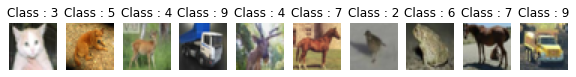

In [8]:
pltsize = 1
plt.figure(figsize=(10*pltsize, pltsize))
for i in range(10):
    plt.subplot(1,10,i+1)
    plt.axis('off')
    plt.imshow(np.transpose(X_train[i],(1,2,0)))
    plt.title('Class : '+str(y_train[i].item()))

#### 4. MLP Design

데이터의 모양을 사람의 눈으로 직접 확인할 수 있도록 이미지 데이터를 시각화 하기 위해 [Width, Height, Channel] 형태로 변환후 [32,32,3]으로 변환해 시각화한다.

In [9]:
#4. MLP 모델 설계
class Net(nn.Module):
    def __init__(self):  # Net 클래스의 인스턴스를 생성했을 때 갖게 되는 성질
        super(Net, self).__init__()
        self.fc1 = nn.Linear(32*32*3, 512)
        self.fc2 = nn.Linear(512, 256)
        self.fc3 = nn.Linear(256,10)
        
    def forward(self, x):
        x = x.view(-1, 32*32*3)
        x = self.fc1(x)
        x = F.relu(x)
        x = self.fc2(x)
        x = F.relu(x)
        x = self.fc3(x)
        x = F.log_softmax(x,dim=1)
        return x

softmax 대신 log_softmax를 쓰는 이유는 Back Propagation을 이용해 학습이 좀 더 원활하게 진행될 수 있도록 하기 위함이다.

In [11]:
#5. Optimizer, Loss Function 설정
model = Net().to(DEVICE)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()

print(model)

Net(
  (fc1): Linear(in_features=3072, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=256, bias=True)
  (fc3): Linear(in_features=256, out_features=10, bias=True)
)


In [12]:
#6. MLP 모델 학습을 진행하여 학습 데이터에 대한 모델 성능을 확인하는
# 함수 정의
def train(model,train_loader, optimizer,log_interval):
    model.train()
    for batch_idx, (image,label) in enumerate(train_loader): 
        image = image.to(DEVICE)
        label = label.to(DEVICE)
        optimizer.zero_grad() 
        output = model(image)
        loss = criterion(output, label)
        loss.backward() 
        optimizer.step() 
        
        if batch_idx % log_interval == 0 :
            print("Train Epoch : {} [{}/{}({:.0f}%)] Train Loss : {:.6f}".format(
            Epoch, batch_idx * len(image),
            len(train_loader.dataset), 100.* batch_idx / len(train_loader),
            loss.item()))

In [13]:
#7. 학습되는 과정 속에서 검증 데이터에 대한 모델 성능을 확인하는 함수 정의
def evaluate(model,test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    
    with torch.no_grad(): 
        for image, label in test_loader:
            image = image.to(DEVICE)
            label = label.to(DEVICE)
            output = model(image)
            test_loss += criterion(output, label).item()
            prediction = output.max(1, keepdim=True)[1] 
            correct += prediction.eq(label.view_as(prediction)).sum().item()
            
    test_loss /= len(test_loader.dataset)
    test_accuracy = 100.* correct / len(test_loader.dataset)
    return test_loss, test_accuracy 

In [14]:
#8. MLP 학습을 실행하면서 Train, Test set의 Loss 및 Test Accuracy를 확인하자.
for Epoch in range(1, EPOCHS+1):
    train(model, train_loader, optimizer, log_interval = 200)
    test_loss, test_accuracy = evaluate(model, test_loader)
    print("|n[EPOCH :{}], Test Loss : {:.4f}, Test Accuracy : {:.2f} ".
         format(Epoch, test_loss, test_accuracy))

Train Epoch : 1 [0/50000(0%)] Train Loss : 2.279318
Train Epoch : 1 [6400/50000(13%)] Train Loss : 1.977035
Train Epoch : 1 [12800/50000(26%)] Train Loss : 1.877690
Train Epoch : 1 [19200/50000(38%)] Train Loss : 1.864806
Train Epoch : 1 [25600/50000(51%)] Train Loss : 2.101465
Train Epoch : 1 [32000/50000(64%)] Train Loss : 1.779279
Train Epoch : 1 [38400/50000(77%)] Train Loss : 1.817122
Train Epoch : 1 [44800/50000(90%)] Train Loss : 1.609660
|n[EPOCH :1], Test Loss : 0.0537, Test Accuracy : 38.10 
Train Epoch : 2 [0/50000(0%)] Train Loss : 1.722970
Train Epoch : 2 [6400/50000(13%)] Train Loss : 1.578827
Train Epoch : 2 [12800/50000(26%)] Train Loss : 2.108623
Train Epoch : 2 [19200/50000(38%)] Train Loss : 1.758209
Train Epoch : 2 [25600/50000(51%)] Train Loss : 2.144308
Train Epoch : 2 [32000/50000(64%)] Train Loss : 1.621972
Train Epoch : 2 [38400/50000(77%)] Train Loss : 2.127620
Train Epoch : 2 [44800/50000(90%)] Train Loss : 1.621386
|n[EPOCH :2], Test Loss : 0.0503, Test Accu

### [예제 4-2] CIFAR-10 데이터 CNN 설계하기

In [15]:
#4. MLP 모델 설계
class CNN(nn.Module):
    def __init__(self):  # Net 클래스의 인스턴스를 생성했을 때 갖게 되는 성질
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(
        in_channels = 3,
        out_channels = 8,
        kernel_size = 3,
        padding = 1)
        self.conv2 = nn.Conv2d(
        in_channels = 8,
        out_channels = 16,
        kernel_size = 3,
        padding = 1)
        self.pool = nn.MaxPool2d(
        kernel_size = 2,
        stride = 2)
        self.fc1 = nn.Linear(8*8*16, 64)
        self.fc2 = nn.Linear(64, 32)
        self.fc3 = nn.Linear(32,10)
        
    def forward(self, x):
        x = self.conv1(x)
        x = F.relu(x)
        x = self.pool(x)
        x = self.conv2(x)
        x = F.relu(x)
        x = self.pool(x)
        
        x = x.view(-1, 8*8*16)
        x = self.fc1(x)
        x = F.relu(x)
        x = self.fc2(x)
        x = F.relu(x)
        x = self.fc3(x)
        x = F.log_softmax(x)
        return x

In [17]:
#5. Optimizer, Loss Function 설정
model = CNN().to(DEVICE)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()

print(model)

CNN(
  (conv1): Conv2d(3, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(8, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=1024, out_features=64, bias=True)
  (fc2): Linear(in_features=64, out_features=32, bias=True)
  (fc3): Linear(in_features=32, out_features=10, bias=True)
)


In [18]:
#8. MLP 학습을 실행하면서 Train, Test set의 Loss 및 Test Accuracy를 확인하자.
for Epoch in range(1, EPOCHS+1):
    train(model, train_loader, optimizer, log_interval = 200)
    test_loss, test_accuracy = evaluate(model, test_loader)
    print("|n[EPOCH :{}], Test Loss : {:.4f}, Test Accuracy : {:.2f} ".
         format(Epoch, test_loss, test_accuracy))

<ipython-input-15-cecc6b4c660a>:36: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  x = F.log_softmax(x)


Train Epoch : 1 [0/50000(0%)] Train Loss : 2.319187
Train Epoch : 1 [6400/50000(13%)] Train Loss : 2.085388
Train Epoch : 1 [12800/50000(26%)] Train Loss : 1.852329
Train Epoch : 1 [19200/50000(38%)] Train Loss : 1.801341
Train Epoch : 1 [25600/50000(51%)] Train Loss : 1.820455
Train Epoch : 1 [32000/50000(64%)] Train Loss : 1.735185
Train Epoch : 1 [38400/50000(77%)] Train Loss : 1.752130
Train Epoch : 1 [44800/50000(90%)] Train Loss : 1.692538
|n[EPOCH :1], Test Loss : 0.0461, Test Accuracy : 45.84 
Train Epoch : 2 [0/50000(0%)] Train Loss : 1.647968
Train Epoch : 2 [6400/50000(13%)] Train Loss : 1.588406
Train Epoch : 2 [12800/50000(26%)] Train Loss : 1.565391
Train Epoch : 2 [19200/50000(38%)] Train Loss : 1.308169
Train Epoch : 2 [25600/50000(51%)] Train Loss : 1.636639
Train Epoch : 2 [32000/50000(64%)] Train Loss : 1.589996
Train Epoch : 2 [38400/50000(77%)] Train Loss : 1.139324
Train Epoch : 2 [44800/50000(90%)] Train Loss : 1.351896
|n[EPOCH :2], Test Loss : 0.0422, Test Accu

결론 : MLP보다 CNN이 더 결과가 좋다.